**`Run the following cell to install lyricsgenius:`**

In [1]:
#!pip install lyricsgenius

**`Import Packages:`**

In [2]:
import boto3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Spotify_Analysis import *
import transformers as hf
from torch.utils.data import Dataset, DataLoader
import gensim.downloader

%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")

# `Calculating Similarity between Ay-Yo! User Profiles`
`Marti Heit and Emma Rainer`

## Task 1: Data Generation

### Load Glove Embeddings

### Genius API
Leverage genius API to scrape relevant song lyrics. Using glove embeddings, find a word vector centroid for the text of a particular song.

In [3]:
genius = Genius(GENIUS_API_TOKEN) # Token stored in Spotify_Analysis.py

## Profile Similarity of Ay-Yo users

### Pull Users and Posts from Ay-Yo!

In [4]:
with open('aws_access_key.txt', 'r') as f:
     AWS_ACCESS_KEY = f.read().split('\n')[0]
with open('aws_secret_access_key.txt', 'r') as f:
     AWS_SECRET_ACCESS_KEY = f.read().split('\n')[0]

users_to_posts = get_users_to_posts(AWS_ACCESS_KEY, AWS_SECRET_ACCESS_KEY)

In [5]:
users_to_lyrics = get_users_to_lyrics(users_to_posts, GENIUS_API_TOKEN)

Searching for "Forever After All" by Luke Combs...
Done.
Searching for "Being In Love" by Wet Leg...
Done.
Searching for "Last Caress - C.I. Recording 1978" by Misfits...
No results found for: 'Last Caress - C.I. Recording 1978 Misfits'
Searching for "Ribs" by Lorde...
Done.
Searching for "blue" by keshi...
Done.
Searching for "I Gotta Feeling" by Black Eyed Peas...
Searching for "I Gotta Feeling" by Black Eyed Peas...
Done.
Searching for "I Love You." by Kaivon...
Done.
Searching for "Violent Crimes" by Kanye West...
Done.
Searching for "Do It To It" by ACRAZE...
Done.
Searching for "Set Me Free (feat. MAX)" by Oliver Heldens...
Done.
Searching for "less of you" by keshi...
Done.
Searching for "Down with the Sickness" by Disturbed...
Done.
Searching for "she likes spring, I prefer winter" by slchld...
Done.
Searching for "Ghost" by Justin Bieber...
Done.
Searching for "Places We Don't Know" by Kasbo...
Specified song does not contain lyrics. Rejecting.
Searching for "September" by Ear

### Generate Fake Users for Validation

In [7]:
users_to_lyrics['Kanye West'] = get_song_list('Kanye West', GENIUS_API_TOKEN, 10)
users_to_lyrics['Kid Cudi'] = get_song_list('Kid Cudi', GENIUS_API_TOKEN, 10)
users_to_lyrics['Big Sean'] = get_song_list('Big Sean', GENIUS_API_TOKEN, 10)
users_to_lyrics['A$AP Rocky'] = get_song_list('A$AP Rocky', GENIUS_API_TOKEN, 10)
users_to_lyrics['Pusha T'] = get_song_list('Pusha T', GENIUS_API_TOKEN, 10)
users_to_lyrics['The Wiggles'] = get_song_list('The Wiggles', GENIUS_API_TOKEN, 10)

Searching for songs by Kanye West...

Song 1: "Mercy"
Song 2: "Father Stretch My Hands, Pt. 1"
Song 3: "Monster"
Song 4: "Ultralight Beam"
Song 5: "Bound 2"
Song 6: "New Slaves"
Song 7: "Blood on the Leaves"
Song 8: "Black Skinhead"
Searching for songs by Kanye West...

Song 1: "Mercy"
Song 2: "Father Stretch My Hands, Pt. 1"
Song 3: "Monster"
Song 4: "Ultralight Beam"
Song 5: "Bound 2"
Song 6: "New Slaves"
Song 7: "Blood on the Leaves"
Song 8: "Black Skinhead"
Song 9: "Runaway"
Song 10: "No More Parties In LA"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Kid Cudi...

Song 1: "Just What I Am"
Song 2: "Pursuit of Happiness (Nightmare)"
Song 3: "Day ‘N’ Nite (Nightmare)"
Song 4: "Soundtrack 2 My Life"
Song 5: "Mr. Rager"
Song 6: "The Prayer"
Song 7: "Erase Me"
Song 8: "Man on the Moon (The Anthem)"
Song 9: "King Wizard"
Song 10: "By Design"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Big Sean...

Song 1: "

In [8]:
class AyyoDataset(Dataset):
    def __init__(self, users_to_lyrics, word_embedding, tokenizer):
        self.users_to_lyrics = users_to_lyrics
        self.word_emb = word_embedding
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.users_to_lyrics)
    
    def __getitem__(self, idx):
        if isinstance(idx, int):
            key = list(self.users_to_lyrics.keys())[idx]
        else:
            key = idx
        lyrics_list = self.users_to_lyrics[key]
        centroid = compute_centroid(lyrics_list, self.word_emb, self.tokenizer)
        return key, centroid

In [9]:
user2idx = {u:i for i, u in enumerate(list(users_to_lyrics.keys()))}

## Calculating Simlarity

### Using Pretrained GloVe Embeddings with Custom Tokenization

In [10]:
glove = load_glove('glove.6B.300d.txt')  # dictionary

In [11]:
dataset = AyyoDataset(users_to_lyrics, glove, tokenizer=None)
dataloader = DataLoader(dataset)

In [12]:
user1, centroid1 = dataset[12]
user2, centroid2 = dataset[15]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between emmamnrainer and marti.heit is 2.933372544706823


In [13]:
user1, centroid1 = dataset[user2idx['trenthamner']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between trenthamner and marti.heit is 1.4222574275689739


In [14]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and marti.heit is 3.188460646336762


In [15]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['emmamnrainer']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and emmamnrainer is 2.3116189494649015


In [16]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['Pusha T']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and Pusha T is 2.4410841230525104


In [17]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['The Wiggles']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and The Wiggles is 0.8747930103806878


#### Initial Observations
- Similarity between Ay-Yo! users is quite high
- Similarity between similar artists is high
- Similarity between non-similar artists is low 

#### Using Pretrained GloVe Embeddings with Pretrained Autotokenizer 

In [18]:
tokenizer = hf.AutoTokenizer.from_pretrained('bert-base-uncased')

In [19]:
dataset = AyyoDataset(users_to_lyrics, glove, tokenizer=tokenizer)
dataloader = DataLoader(dataset)

In [20]:
user1, centroid1 = dataset[12]
user2, centroid2 = dataset[15]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (842 > 512). Running this sequence through the model will result in indexing errors


Similarity score between emmamnrainer and marti.heit is 4.85455328419959


In [21]:
user1, centroid1 = dataset[user2idx['trenthamner']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between trenthamner and marti.heit is 2.2158771756560953


In [22]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and marti.heit is 5.393656290567637


In [23]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['emmamnrainer']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and emmamnrainer is 4.251840166878206


In [24]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['Pusha T']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and Pusha T is 3.6074956761462285


In [25]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['The Wiggles']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and The Wiggles is 1.41452491056156


#### Observations
- Trends are the same, but differences are more pronouced

#### Using Wikipedia GloVe Embeddings with Pretrained Autotokenizer

In [26]:
wiki_emb = gensim.downloader.load('glove-wiki-gigaword-100')

In [27]:
dataset = AyyoDataset(users_to_lyrics, wiki_emb, tokenizer=tokenizer)
dataloader = DataLoader(dataset)

In [28]:
user1, centroid1 = dataset[12]
user2, centroid2 = dataset[15]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between emmamnrainer and marti.heit is 6.030698942969794


In [29]:
user1, centroid1 = dataset[user2idx['trenthamner']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between trenthamner and marti.heit is 2.570535760660875


In [30]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and marti.heit is 6.5895859605959455


In [31]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['emmamnrainer']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and emmamnrainer is 5.6360329248659


In [32]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['Pusha T']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and Pusha T is 4.138384085050752


In [33]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['The Wiggles']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and The Wiggles is 1.5429937150739725


#### Using Twitter GloVe Embeddings with Pretrained Autotokenizer

In [34]:
import gensim.downloader
glove_emb = gensim.downloader.load('glove-twitter-200')

In [35]:
dataset = AyyoDataset(users_to_lyrics, glove_emb, tokenizer=tokenizer)
dataloader = DataLoader(dataset)

In [36]:
user1, centroid1 = dataset[12]
user2, centroid2 = dataset[15]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between emmamnrainer and marti.heit is 4.598116953244766


In [37]:
user1, centroid1 = dataset[user2idx['trenthamner']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between trenthamner and marti.heit is 2.1478190514230704


In [38]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['marti.heit']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and marti.heit is 5.16914736278516


In [39]:
user1, centroid1 = dataset[user2idx['mateen_saifyan']]
user2, centroid2 = dataset[user2idx['emmamnrainer']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between mateen_saifyan and emmamnrainer is 3.8491131289041687


In [40]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['Pusha T']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and Pusha T is 3.060854893774542


In [41]:
user1, centroid1 = dataset[user2idx['Kanye West']]
user2, centroid2 = dataset[user2idx['The Wiggles']]
print(f"Similarity score between {user1} and {user2} is {similarity_score(centroid1, centroid2)}")

Similarity score between Kanye West and The Wiggles is 1.3176041729903967


#### Observations
- Differences seem less pronounced with Twitter embedding than with Wikipedia embedding
- In general, autotokenization seems to give more pronouced differences than word tokenization

### Final Algorithm Choice

- Pretrained subword autotokenization
- Pretrained GloVe Wikipedia embeddings

In [42]:
dataset = AyyoDataset(users_to_lyrics, wiki_emb, tokenizer=tokenizer)
dataloader = DataLoader(dataset)

### Validating Results

In [43]:
kanye_similarities = {artist: similarity_score(dataset[user2idx['Kanye West']][1], dataset[user2idx[artist]][1])\
                     for artist in ['Pusha T', 'Big Sean', 'A$AP Rocky', 'Kid Cudi', 'The Wiggles']}

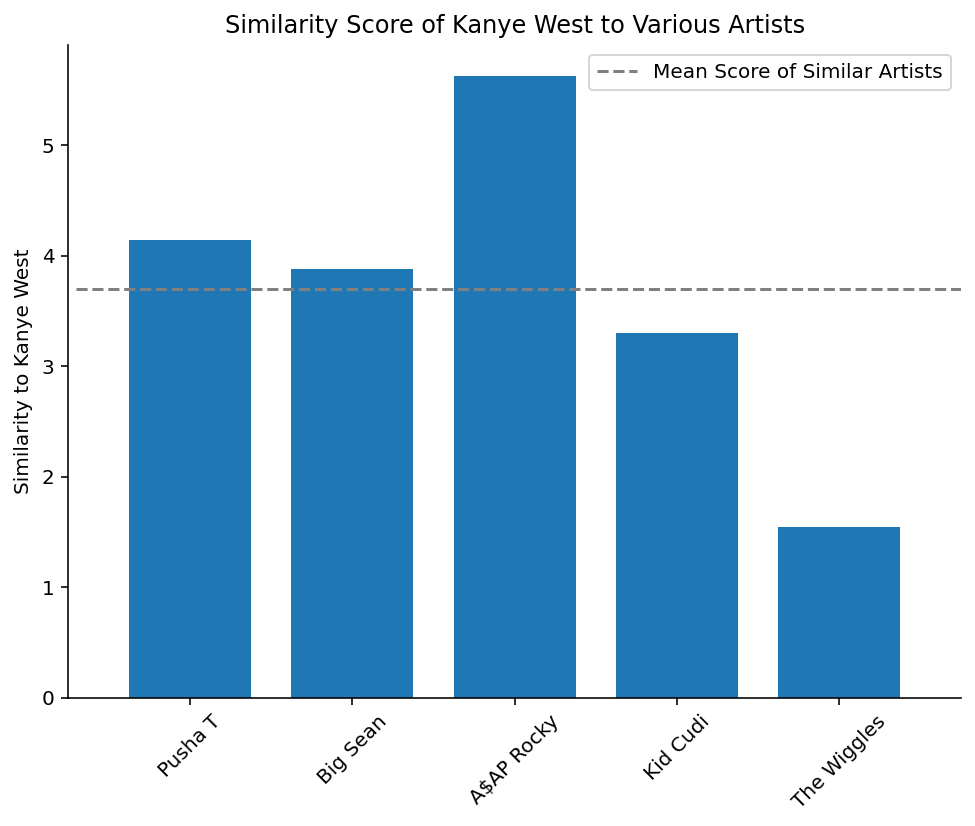

In [80]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlim(-0.75, 4.75)
plt.bar(x=kanye_similarities.keys(),height=[v for v in kanye_similarities.values()], width=0.75)
plt.hlines(np.mean([v for v in kanye_similarities.values()]), xmin=-0.7, xmax=4.75,
          color='grey', linestyle='dashed', label='Mean Score of Similar Artists')
plt.xticks(rotation = 45)
plt.title('Similarity Score of Kanye West to Various Artists')
plt.ylabel('Similarity to Kanye West')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.savefig('kanye_barchart.png', bbox_inches='tight', pad_inches=0.1)

### Find Most Similar Users

In [45]:
get_most_similar_users('marti.heit', dataset)[1:5]

[('mateen_saifyan', 6.5895859605959455),
 ('yuuknowwhoitis', 6.1180410098315345),
 ('31lve7qlslqnsxb6byqkmqbdqgsu', 6.087149022660887),
 ('emmamnrainer', 6.030698942969794)]

In [83]:
get_most_similar_users('marti.heit', dataset)[-1]

('1210490048', 0.9182611924401537)

In [46]:
user_similarity_matrix = create_user_similarity_matrix(users_to_lyrics, dataset)

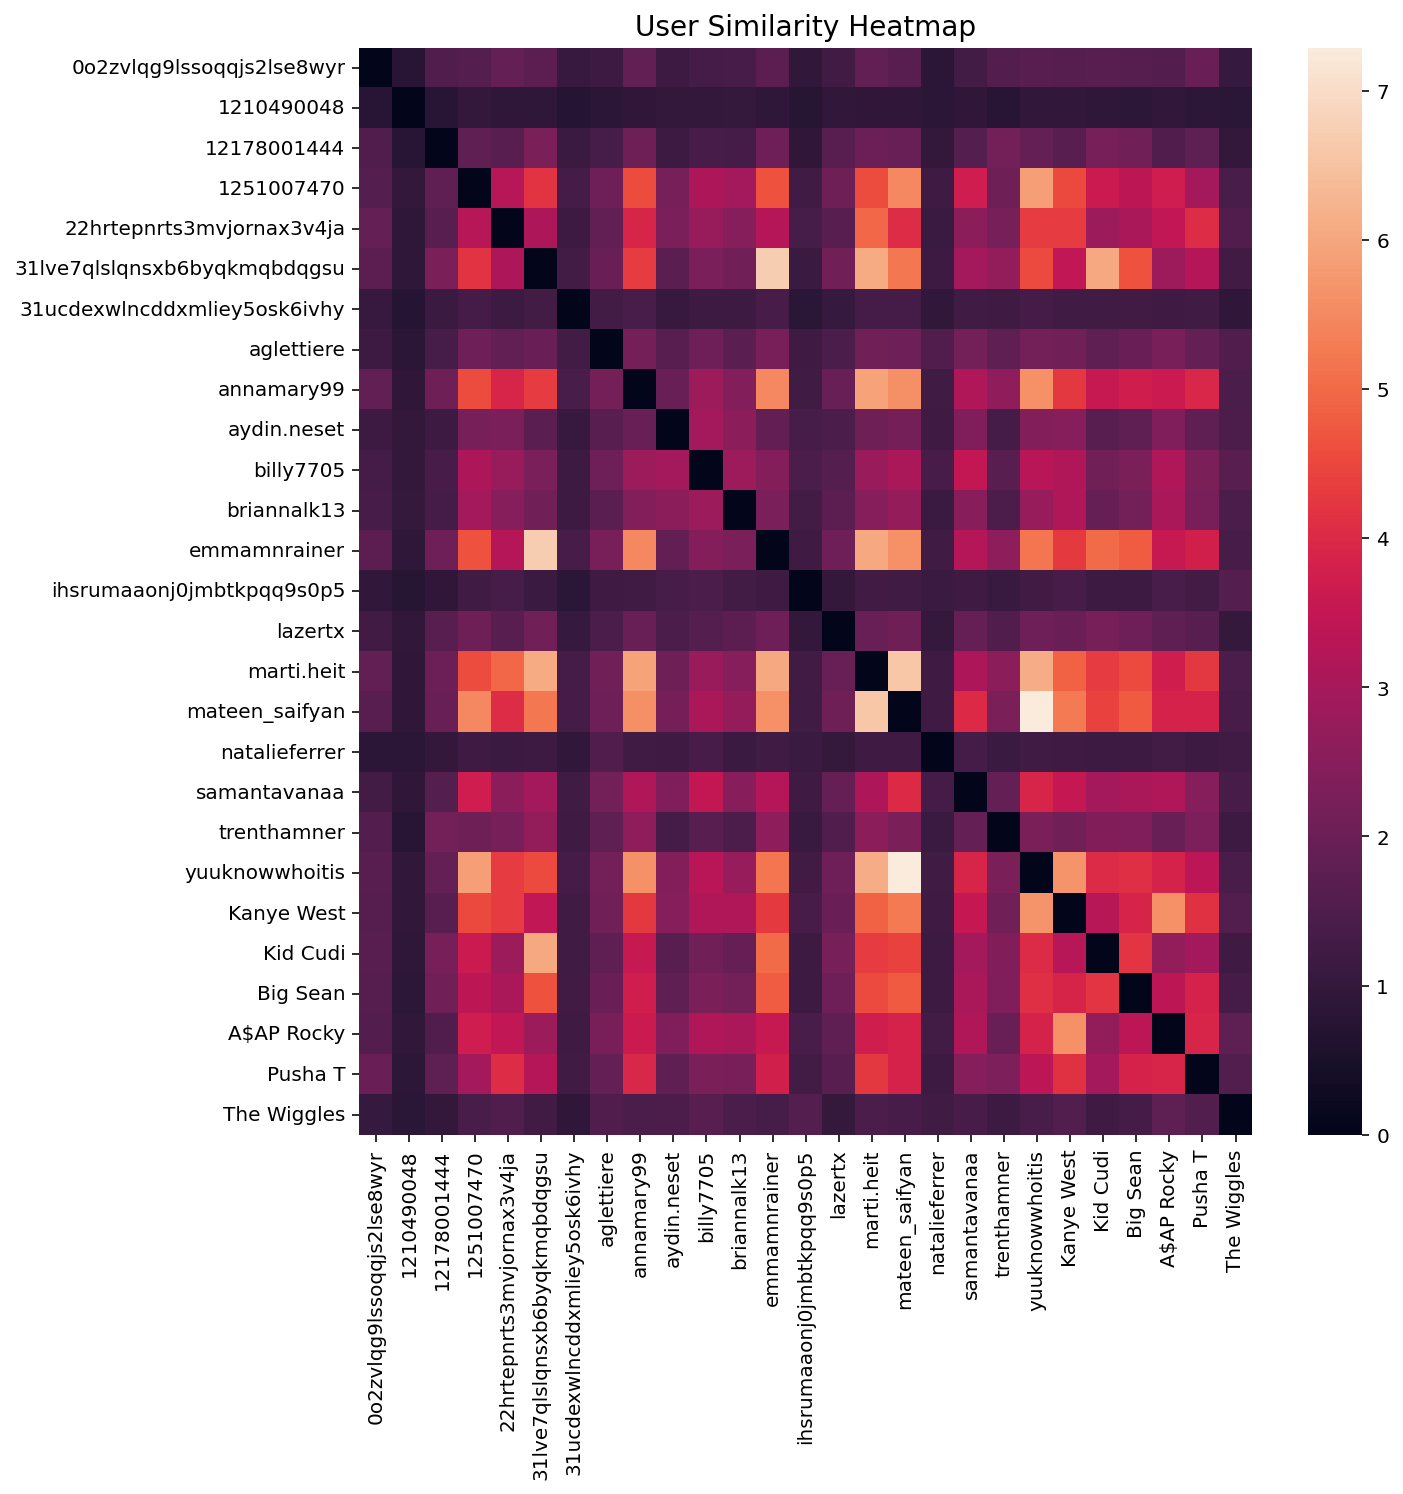

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(user_similarity_matrix.astype('float64'))
ax.set_title('User Similarity Heatmap', size=14)
fig.show()
plt.savefig('user_heatmap.png', bbox_inches='tight', pad_inches=0.1)

## Task 2: Use generated data to predict if a user will like a song

#### Generate Dataframe

So im thinking we generate data like:

features:
- unique user centroid
- new song
- 1/0 rating

In [48]:
# data = {'user_embedding': [user1_centroid, user1_centroid, user1_centroid, user2_centroid, user2_centroid,\
#                       user2_centroid, user3_centroid, user3_centroid,user3_centroid],
#         'most_similar_user': [user2_centroid,user2_centroid,user2_centroid,user1_centroid,user1_centroid,\
#                          user1_centroid, user2_centroid, user2_centroid, user2_centroid],
#         'new_song': [lana_lyrics, olivia_lyrics, kendrick_lyrics, fiona_lyrics, zach_lyrics, chappell_lyrics,\
#                  amine_lyrics, kanye_lyrics, mac_lyrics]}

In [49]:
# df = pd.DataFrame.from_dict(data)
# df['new_song'] = [doc2vec(lyrics, glove) for lyrics in df['new_song']]
# df['label'] = 1
# df.head()

#### Negative Sampling

I'm thinking that once we have a lot of sample users, we can take the user that is most dissimilar from a given user and give all of those songs a negative rating? idk 

#### Modeling

In [50]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

In [51]:
# # Using pretrained embeddings initially? idk need to work on this

# class MF(nn.Module):
#     def __init__(self, num_users, num_items, emb_size=300):
#         super(MF, self).__init__()
#         self.n_u = num_users
#         self.n_v = num_items
        
#         self.user_emb = nn.Embedding(num_users, emb_size)
#         self.user_bias = nn.Embedding(num_users, 1)
        
#         self.item_emb = nn.Embedding(num_items, emb_size) 
#         self.item_bias = nn.Embedding(num_items, 1)
        
#         self.user_emb.weight.data.uniform_(0,0.05)   # range
#         self.item_emb.weight.data.uniform_(0,0.05)
        
#         self.user_bias.weight.data.uniform_(-0.01,0.01) # range
#         self.item_bias.weight.data.uniform_(-0.01,0.01)

#     def forward(self, u, v):
#         b = self.user_bias(u).squeeze()
#         c = self.item_bias(v).squeeze()
#         U = self.user_emb(u)
#         V = self.item_emb(v)
#         uv = (U*V).sum(1) + b + c
#         return uv

$$\text {similarity score = }\frac 1 {\lVert \vec u_i - \vec u_j \rVert}$$